# Imports

In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import re, os
from datetime import datetime
import random
import time
import ensemble_boxes
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet
import shutil

In [3]:
sys.path.insert(0, "../input/efficientdet")

# Data Loading and Processing

In [4]:
mkdir train moved_dataset out

In [5]:
DIR_INPUT = '/kaggle/input/global-wheat-detection' # data folder
DIR_TRAIN = f'{DIR_INPUT}/train' # train data 
DIR_TEST = f'{DIR_INPUT}/test' # test data

SYNTHETIC_DIRS = ['/syntheticnotebook/output', 
                  '/synthetic1/0-49', 
                  '/synthetic2/50-99', 
                  '/synthetic3/100-149', 
                  '/synthetic4/150-199', 
                  '/synthetic5/200-249', 
                  '/synthetic6/250-299', 
                  '/synthetic7/300-349', 
                  '/synthetic8/350-399', 
                  '/synthetic9/400-449',
                  '/synthetic10/450-499',
                  '/synthetic11/500-549',
                  '/synthetic12/1732-1781',
                  '/synthetic13/1782-1831',
                  '/synthetic14/1832-1881',
                  '/synthetic15/1882-1931',
                  '/synthetic16/2132-2181',
                  '/synthetic17/1982-2031',
                  '/synthetic18/2032-2081',
                  '/synthetic19/2082-2131',
                  '/synthetic20/2182-2231',
                  '/synthetic21/2232-2281',
                  '/synthetic22/2282-2331',
                  '/synthetic23/1932-1981',
                  '/testsynthetic/output',
                 ]


DIR_WEIGHTS = '/kaggle/input/effdetfold0' 

WEIGHTS_FILE = f'{DIR_WEIGHTS}/full-effdet5-cutmix-augmix/best-checkpoint-025epoch.bin' # saved wiehgts to be loaded

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
N_CLASSES = 2
DEVICE # make sure its cuda

device(type='cuda')

In [6]:
#PredictionString = [#boxes as double], [bbox information for each bbox (xmin, ymin, width, height)]

test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [7]:
for synthetic_dir in SYNTHETIC_DIRS:
    for file in os.listdir(f'/kaggle/input/{synthetic_dir}'):
        shutil.copy(f'/kaggle/input{synthetic_dir}/{file}', '/kaggle/working/moved_dataset')

In [8]:
os.chdir('/kaggle/working/moved_dataset')
extension = 'csv'
all_filenames = [i for i in glob(f'*.{extension}')]

In [9]:
def gnfs(fname):
    res = [i for i in fname if i.isdigit()]
    return ''.join(res)

for fname in glob('*.{}'.format(extension)):
    df = pd.read_csv(fname)
    num_array = ['out{}'.format(gnfs(fname)) for i in range(df.shape[0])]
    df['image_id'] = num_array
    df.to_csv(f'/kaggle/working/train/{fname}', index=False, encoding='utf-8-sig')

In [10]:
os.chdir('/kaggle/working/train')
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f'/kaggle/working/train/{f}') for f in all_filenames])
#export to csv
combined_csv.to_csv("/kaggle/working/train.csv", index=False, encoding='utf-8-sig')
os.chdir('/kaggle/working')

In [11]:
#marking = pd.read_csv('../input/global-wheat-detection/train.csv')
marking = pd.read_csv('/kaggle/working/train.csv')

# separate bounding box into four different columns xywh, (min_x, min_y, weigth, height)
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

marking

,id,sick,image_id,x,y,w,h
0,Train_484.jpg,1,out461,0.0,0.0,64.0,43.0
1,Train_1475.jpg,1,out461,64.0,0.0,64.0,43.0
2,Train_318.jpg,1,out461,128.0,0.0,64.0,43.0
3,Train_1603.jpg,1,out461,192.0,0.0,64.0,43.0
4,Train_348.jpg,0,out461,256.0,0.0,64.0,43.0
...,...,...,...,...,...,...,...
1230025,Train_1243.jpg,1,out174,1344.0,1204.0,64.0,43.0
1230026,Train_308.jpg,1,out174,1408.0,1204.0,64.0,43.0
1230027,Train_1314.jpg,1,out174,1472.0,1204.0,64.0,43.0
1230028,Train_691.jpg,0,out174,1600.0,1204.0,64.0,43.0


In [12]:
DATA_ROOT_PATH = './moved_dataset' # datasetretriever class will be overrided later for training
#DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [13]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).cuda().float()  
    predictions = []
    with torch.no_grad():
        outputs = model(images, torch.tensor([1]*images.shape[0]).float().cuda())
        gc.collect()
        torch.cuda.empty_cache()
    for i in range(images.shape[0]):
        boxes = outputs[i].detach().cpu().numpy()[:,:4]    
        scores = outputs[i].detach().cpu().numpy()[:,4]
        indexes = np.where(scores > score_threshold)[0]
        boxes = boxes[indexes]
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
        predictions.append({
            'boxes': boxes[indexes],
            'scores': scores[indexes],
        })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.43, skip_box_thr=0.43, weights=None): 
    # weighted boxes fusion; https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

## Augmentations

In [14]:
# data augmentations
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose([
        A.Resize(height=512, width=512, p=1.0),
        ToTensorV2(p=1.0)
    ], p=1)

def get_test_transforms():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], p=1)

# Load Model from Weights

In [15]:
def load_net_eval(checkpoint_path):
    # load edet
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    # adjust for data, https://github.com/rwightman/efficientdet-pytorch/blob/master/effdet/efficientdet.py (line 364 for HeadNet)
    config.num_classes = 1
    config.image_size=512
    # manually set epsilon and momentum
    # epsilon - https://gluon.mxnet.io/chapter04_convolutional-neural-networks/cnn-batch-norm-scratch.html
    # momentum - https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123570222.pdf
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    # load onto a cuda from a weight file
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    net.load_state_dict(checkpoint['model_state_dict'])

    # clear garbage
    del checkpoint
    gc.collect()

    # https://github.com/rwightman/efficientdet-pytorch/blob/master/effdet/bench.py, line 79
    net = DetBenchEval(net, config)
    net.eval()
    return net.cuda()

model = load_net_eval(WEIGHTS_FILE)

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch)) 

# test images
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
    )


test_data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [17]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

# Pseudolabels for test dataset

# Retrain with new pseudo-data

In [18]:
train_df = pd.read_csv(f'/kaggle/working/train.csv')
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

# SAME THING AS ABOVE AMAZING
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox', 'sick', 'id'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

train_df.head()

,image_id,x,y,w,h
0,out461,0.0,0.0,64.0,43.0
1,out461,64.0,0.0,64.0,43.0
2,out461,128.0,0.0,64.0,43.0
3,out461,192.0,0.0,64.0,43.0
4,out461,256.0,0.0,64.0,43.0


In [19]:
for i, row in train_df.iterrows():
    if row['x'] == 1792 or row['y'] == 1204: 
        train_df.drop(index=i, inplace=True)


In [20]:
train_df.tail()

,image_id,x,y,w,h
1230005,out174,1472.0,1161.0,64.0,43.0
1230006,out174,1536.0,1161.0,64.0,43.0
1230007,out174,1600.0,1161.0,64.0,43.0
1230008,out174,1664.0,1161.0,64.0,43.0
1230009,out174,1728.0,1161.0,64.0,43.0


In [21]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchTrain(net, config)
    return net.cuda()

model = load_net(WEIGHTS_FILE)

In [22]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-300:]
train_ids = image_ids[:-300]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]

#frames = [train_df, test_df_pseudo]

#train_df = pd.concat(frames, ignore_index=True)
train_df.tail()

,image_id,x,y,w,h
1230005,out174,1472.0,1161.0,64.0,43.0
1230006,out174,1536.0,1161.0,64.0,43.0
1230007,out174,1600.0,1161.0,64.0,43.0
1230008,out174,1664.0,1161.0,64.0,43.0
1230009,out174,1728.0,1161.0,64.0,43.0


# Training Dataset

In [23]:
TRAIN_ROOT_PATH = './moved_dataset'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)
#         image, boxes = self.load_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        if 'nvnn' in image_id:
            image = cv2.imread(f'{DIR_TEST}/{image_id[4:]}.jpg', cv2.IMREAD_COLOR)
        else:
            image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = DatasetRetriever(
    image_ids=np.array(list(set(train_df['image_id'].values))).astype('O'),
    marking=train_df,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=np.array(list(set(train_df['image_id'].values))).astype('O'),
    marking=train_df,
    transforms=get_valid_transforms(),
    test=False,
)


indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-200])
validation_dataset = torch.utils.data.Subset(validation_dataset, indices[-200:])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [25]:
train_dataset[0]

(tensor([[[0.3007, 0.3111, 0.3719,  ..., 0.3679, 0.3478, 0.3297],
          [0.3172, 0.3356, 0.4389,  ..., 0.3695, 0.3554, 0.3356],
          [0.3080, 0.3308, 0.4179,  ..., 0.3810, 0.3644, 0.3384],
          ...,
          [0.4006, 0.4073, 0.4283,  ..., 0.8191, 0.7369, 0.7534],
          [0.4959, 0.4842, 0.4832,  ..., 0.6401, 0.8488, 0.7737],
          [0.4296, 0.4765, 0.4922,  ..., 0.5251, 0.8112, 0.8354]],
 
         [[0.3945, 0.3771, 0.4112,  ..., 0.4514, 0.4364, 0.4296],
          [0.4110, 0.4012, 0.4690,  ..., 0.4594, 0.4499, 0.4332],
          [0.3942, 0.3968, 0.4613,  ..., 0.4849, 0.4704, 0.4462],
          ...,
          [0.5183, 0.5242, 0.5465,  ..., 0.9165, 0.8420, 0.8671],
          [0.5928, 0.5816, 0.5916,  ..., 0.7539, 0.9649, 0.8955],
          [0.5023, 0.5560, 0.5931,  ..., 0.6497, 0.9346, 0.9597]],
 
         [[0.2399, 0.2179, 0.2341,  ..., 0.2864, 0.2675, 0.2512],
          [0.2401, 0.2353, 0.2986,  ..., 0.2869, 0.2658, 0.2380],
          [0.2490, 0.2453, 0.2708,  ...,

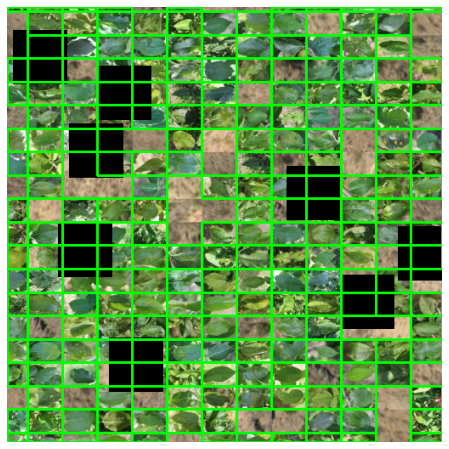

In [26]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

# Train Efficientdet

In [27]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'./out/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
        return self.model

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [28]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4 
    n_epochs = 10
    lr = 0.0002

    folder = 'out'

    verbose = True
    verbose_step = 1

    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [29]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    model.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=model, device=device, config=TrainGlobalConfig)
    return fitter.fit(train_loader, val_loader)

In [30]:
if len(os.listdir(DIR_TEST)) > 9:
    model = run_training()

Fitter prepared. Device is cuda:0

2021-03-01T10:18:11.523675
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 0.16456, time: 1029.25873
[RESULT]: Val. Epoch: 0, summary_loss: 2.11516, time: 83.61394

2021-03-01T10:36:46.293880
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.08570, time: 1050.13700
[RESULT]: Val. Epoch: 1, summary_loss: 2.39577, time: 88.59626

2021-03-01T10:55:46.298291
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.06779, time: 1058.12311
[RESULT]: Val. Epoch: 2, summary_loss: 2.59776, time: 85.86626

2021-03-01T11:14:51.631787
LR: 0.0001
[RESULT]: Train. Epoch: 3, summary_loss: 0.05106, time: 1023.54136
[RESULT]: Val. Epoch: 3, summary_loss: 2.65208, time: 80.95532

2021-03-01T11:33:17.617666
LR: 0.0001
[RESULT]: Train. Epoch: 4, summary_loss: 0.04550, time: 1047.72950
[RESULT]: Val. Epoch: 4, summary_loss: 2.94013, time: 85.16512

2021-03-01T11:52:11.721231
LR: 5e-05
[RESULT]: Train. Epoch: 5, summary_loss: 0.04043, time: 1039.25676
[RESULT]: Val. E

In [31]:
model.eval()
torch.save({
    'model_state_dict': model.model.state_dict()
}, '/kaggle/working/out/pl.bin')

In [32]:
rm-rf moved_dataset train

In [33]:
def make_archive(source, destination):
        base = os.path.basename(destination)
        name = base.split('.')[0]
        format = base.split('.')[1]
        archive_from = os.path.dirname(source)
        archive_to = os.path.basename(source.strip(os.sep))
        print(source, destination, archive_from, archive_to)
        shutil.make_archive(name, format, archive_from, archive_to)
        shutil.move('%s.%s'%(name,format), destination)

make_archive('./out', 'out.zip')

print("done with zip")

./out out.zip . out
done with zip


# Predictions

In [34]:
DATA_ROOT_PATH = '../input/syntheticlfdatatest/output'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [35]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)


data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

# TTA

In [36]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [37]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), TTARotate180(), TTARotate270(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [38]:
def load_net_eval(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval()
    return net.cuda()

model = load_net_eval('./out/pl.bin')

In [39]:
def make_tta_predictions(images, score_threshold=0.25):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = model(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

In [40]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample)
plt.plot()

NameError: name 'images' is not defined

In [41]:
images

NameError: name 'images' is not defined

In [42]:
results = []

for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [43]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
